# Job Search II: Search and Separation


<a id='index-0'></a>

## Contents

- [Job Search II: Search and Separation](#Job-Search-II:-Search-and-Separation)  
  - [Overview](#Overview)  
  - [The Model](#The-Model)  
  - [Solving the Model using Dynamic Programming](#Solving-the-Model-using-Dynamic-Programming)  
  - [Implementation](#Implementation)  
  - [The Reservation Wage](#The-Reservation-Wage)  
  - [Exercises](#Exercises)  


## Overview

Previously [we looked](mccall_model.html#) at the McCall job search model [[McC70]](https://lectures.quantecon.org/py/zreferences.ipynb#mccall1970) as a way of understanding unemployment and worker decisions

One unrealistic feature of the model is that every job is permanent

In this lecture we extend the McCall model by introducing job separation

Once separation enters the picture, the agent comes to view

- the loss of a job as a capital loss, and  
- a spell of unemployment as an *investment* in searching for an acceptable job  


We’ll need the following imports

In [1]:
import numpy as np
from quantecon.distributions import BetaBinomial
from numba import njit
import matplotlib.pyplot as plt
%matplotlib inline

## The Model

The model concerns the life of an infinitely lived worker and

- the opportunities he or she (let’s say he to save one character) has to work at different wages  
- exogenous events that destroy his current job  
- his decision making process while unemployed  


The worker can be in one of two states: employed or unemployed

He wants to maximize


<a id='equation-objective'></a>
$$
{\mathbb E} \sum_{t=0}^\infty \beta^t u(Y_t) \tag{1}
$$

The only difference from the [baseline model](mccall_model.ipynb#) is that
we’ve added some flexibility over preferences by introducing a utility function $ u $

It satisfies $ u'> 0 $ and $ u'' < 0 $

### Timing and Decisions

Here’s what happens at the start of a given period in our model with search and separation

If currently *employed*, the worker consumes his wage $ w $, receiving utility $ u(w) $

If currently *unemployed*, he

- receives and consumes unemployment compensation $ c $  
- receives an offer to start work *next period* at a wage $ w' $ drawn from a known distribution $ \phi $  


He can either accept or reject the offer

If he accepts the offer, he enters next period employed with wage $ w' $

If he rejects the offer, he enters next period unemployed

When employed, the agent faces a constant probability $ \alpha $ of becoming unemployed at the end of the period

(Note: we do not allow for job search while employed—this topic is taken
up in a [later lecture](jv.ipynb#))

## Solving the Model using Dynamic Programming

Let

- $ v(w) $ be the total lifetime value accruing to a worker who enters the current period *employed* with wage $ w $  
- $ h $ be the total lifetime value accruing to a worker who is *unemployed* this period  


Here *value* means the value of the objective function [(1)](#equation-objective) when the worker makes optimal decisions at all future points in time

Suppose for now that the worker can calculate the function $ v $ and the constant $ h $ and use them in his decision making

Then $ v $ and $ h $  should satisfy


<a id='equation-bell1-mccall'></a>
$$
v(w) = u(w) + \beta [(1-\alpha)v(w) + \alpha h ] \tag{2}
$$

and


<a id='equation-bell2-mccall'></a>
$$
h = u(c) + \beta \sum_{w'} \max \left\{ h, v(w') \right\} \phi(w') \tag{3}
$$

Let’s interpret these two equations in light of the fact that today’s tomorrow is tomorrow’s today

- The left hand sides of equations [(2)](#equation-bell1-mccall) and [(3)](#equation-bell2-mccall) are the values of a worker in a particular situation *today*  
- The right hand sides of the equations are the discounted (by $ \beta $) expected values of the possible situations that worker can be in *tomorrow*  
- But *tomorrow* the worker can be in only one of the situations whose values *today* are on the left sides of our two equations  


Equation [(3)](#equation-bell2-mccall) incorporates the fact that a currently unemployed worker will maximize his own welfare

In particular, if his next period wage offer is $ w' $, he will choose to remain unemployed unless  $ h < v(w') $

Equations [(2)](#equation-bell1-mccall) and [(3)](#equation-bell2-mccall) are the Bellman equations
for this model

Equations [(2)](#equation-bell1-mccall) and [(3)](#equation-bell2-mccall) provide enough information to solve out for both $ v $ and $ h $

Before discussing this, however, let’s make a small extension to the model

### Stochastic Offers

Let’s suppose now that unemployed workers don’t always receive job offers

Instead, let’s suppose that unemployed workers only receive an offer with probability $ \gamma $

If our worker does receive an offer, the wage offer is drawn from $ \phi $ as before

He either accepts or rejects the offer

Otherwise the model is the same

With some thought, you  will be able to convince yourself that $ v $ and $ h $  should now satisfy


<a id='equation-bell01-mccall'></a>
$$
v(w) = u(w) + \beta [(1-\alpha)v(w) + \alpha h ] \tag{4}
$$

and


<a id='equation-bell02-mccall'></a>
$$
h = u(c) +
  \beta (1 - \gamma) h +
  \beta \gamma \sum_{w'} \max \left\{ h, v(w') \right\} \phi(w') \tag{5}
$$

### Solving the Bellman Equations

We’ll use the same iterative approach to solving the Bellman equations that we
adopted in the [first job search lecture](mccall_model.ipynb#)

Here this amounts to

1. make guesses for $ h $ and $ v $  
1. plug these guesses into the right hand sides of [(4)](#equation-bell01-mccall) and [(5)](#equation-bell02-mccall)  
1. update the left hand sides from this rule and then repeat  


In other words, we are iterating using the rules


<a id='equation-bell1001'></a>
$$
v_{n+1} (w') = u(w') + \beta [(1-\alpha)v_n (w') + \alpha h_n ] \tag{6}
$$

and


<a id='equation-bell2001'></a>
$$
h_{n+1} = u(c) +
    \beta (1 - \gamma) h_n +
    \beta \gamma \sum_{w'} \max \{ h_n, v_n(w') \} \phi(w') \tag{7}
$$

starting from some initial conditions $ h_0, v_0 $

As before, the system always converges to the true solutions—in this case,
the $ v $ and $ h $ that solve [(4)](#equation-bell01-mccall) and [(5)](#equation-bell02-mccall)

A proof can be obtained via the Banach contraction mapping theorem

## Implementation

Let’s implement this iterative process

In the code you’ll see that we use a class to store the various parameters and other
objects associated with a given model

This helps to tidy up the code and provides an object that’s easy to pass to functions

The default utility function is a CRRA utility function

In [2]:
# A default utility function

@njit
def u(c, σ):
    if c > 0:
        return (c**(1 - σ) - 1) / (1 - σ)
    else:
        return -10e6

class McCallModel:
    """
    Stores the parameters and functions associated with a given model.
    """

    def __init__(self,
                 α=0.2,        # Job separation rate
                 β=0.98,       # Discount rate
                 γ=0.7,        # Job offer rate
                 c=6.0,        # Unemployment compensation
                 σ=2.0,        # Utility parameter
                 w_vals=None,  # Possible wage values
                 ϕ_vals=None): # Probabilities over w_vals

        self.α, self.β, self.γ, self.c = α, β, γ, c
        self.σ = σ

        # Add a default wage vector and probabilities over the vector using
        # the beta-binomial distribution
        if w_vals is None:
            n = 60  # number of possible outcomes for wage
            self.w_vals = np.linspace(10, 20, n)     # wages between 10 and 20
            a, b = 600, 400  # shape parameters
            dist = BetaBinomial(n-1, a, b)
            self.ϕ_vals = dist.pdf()
        else:
            self.w_vals = w_vals
            self.ϕ_vals = ϕ_vals

The following function returns jitted versions of the Bellman operators $ h $ and $ v $

In [3]:
def operator_factory(mcm, parallel_flag=True):
    """
    mcm is an instance of McCallModel
    """

    α, β, γ, c = mcm.α, mcm.β, mcm.γ, mcm.c
    σ, w_vals, ϕ_vals = mcm.σ, mcm.w_vals, mcm.ϕ_vals

    @njit
    def Q(v, h):
        """
        A jitted function to update the Bellman equations

        """
        v_new = np.empty_like(v)

        for i in range(len(w_vals)):
            w = w_vals[i]
            v_new[i] = u(w, σ) + β * ((1 - α) * v[i] + α * h)

        h_new = u(c, σ) + β * (1 - γ) * h + \
                        β * γ * np.sum(np.maximum(h, v) * ϕ_vals)

        return v_new, h_new

    return Q

The approach is to iterate until successive iterates are closer together than some small tolerance level

We then return the current iterate as an approximate solution

In [4]:
def solve_model(mcm, use_parallel=True, tol=1e-5, max_iter=2000):
    """
    Iterates to convergence on the Bellman equations

    mcm is an instance of McCallModel
    """

    Q = operator_factory(mcm, use_parallel)

    v = np.ones_like(mcm.w_vals)   # Initial guess of v
    h = 1                          # Initial guess of h
    i = 0
    error = tol + 1

    while error > tol and i < max_iter:
        v_new, h_new = Q(v, h)
        error_1 = np.max(np.abs(v_new - v))
        error_2 = np.abs(h_new - h)
        error = max(error_1, error_2)
        v = v_new
        h = h_new
        i += 1

    return v, h

Let’s plot the approximate solutions $ v $ and $ h $ to see what they look like

We’ll use the default parameterizations found in the code above

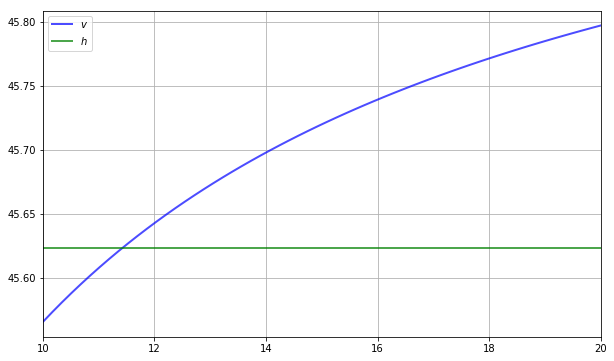

In [5]:
mcm = McCallModel()
v, h = solve_model(mcm)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(mcm.w_vals, v, 'b-', lw=2, alpha=0.7, label='$v$')
ax.plot(mcm.w_vals, [h] * len(mcm.w_vals), 'g-', lw=2, alpha=0.7, label='$h$')
ax.set_xlim(min(mcm.w_vals), max(mcm.w_vals))
ax.legend()
ax.grid()

plt.show()

The value $ v $ is increasing because higher $ w $ generates a higher wage flow conditional on staying employed

## The Reservation Wage

Once $ v $ and $ h $ are known, the agent can use them to make decisions in the face of a given wage offer

If $ v(w) > h $, then working at wage $ w $ is preferred to unemployment

If $ v(w) < h $, then remaining unemployed will generate greater lifetime value

Suppose in particular that $ v $ crosses $ h $ (as it does in the preceding figure)

Then, since $ v $ is increasing, there is a unique smallest $ w $ in the set of possible wages such that $ v(w) \geq h $

We denote this wage $ \bar w $ and call it the reservation wage

Optimal behavior for the worker is characterized by $ \bar w $

- if the  wage offer $ w $ in hand is greater than or equal to $ \bar w $, then the worker accepts  
- if the  wage offer $ w $ in hand is less than $ \bar w $, then the worker rejects  


Here’s a function `compute_reservation_wage` that takes an instance of `McCallModel`
and returns the reservation wage associated with a given model

It uses [np.searchsorted](https://docs.scipy.org/doc/numpy/reference/generated/numpy.searchsorted.html)
to obtain the first $ w $ in the set of possible wages such that $ v(w) > h $

If $ v(w) < h $ for all $ w $, then the function returns np.inf

In [6]:
def compute_reservation_wage(mcm, return_values=False):
    """
    Computes the reservation wage of an instance of the McCall model
    by finding the smallest w such that v(w) > h.

    If v(w) > h for all w, then the reservation wage w_bar is set to
    the lowest wage in mcm.w_vals.

    If v(w) < h for all w, then w_bar is set to np.inf.

    """

    v, h = solve_model(mcm)
    w_idx = np.searchsorted(v - h, 0)

    if w_idx == len(v):
        w_bar = np.inf
    else:
        w_bar = mcm.w_vals[w_idx]

    if return_values == False:
        return w_bar
    else:
        return w_bar, v, h

Let’s use it to look at how the reservation wage varies with parameters

In each instance below we’ll show you a figure and then ask you to reproduce it in the exercises

### The Reservation Wage and Unemployment Compensation

First, let’s look at how $ \bar w $ varies with unemployment compensation

In the figure below, we use the default parameters in the `McCallModel` class, apart from
c (which takes the values given on the horizontal axis)

<img src="https://s3-ap-southeast-2.amazonaws.com/lectures.quantecon.org/py/_static/figures/mccall_resw_c.png" style="width:60%;height:60%">

  
As expected, higher unemployment compensation causes the worker to hold out for higher wages

In effect, the cost of continuing job search is reduced

### The Reservation Wage and Discounting

Next let’s investigate how $ \bar w $ varies with the discount rate

The next figure plots the reservation wage associated with different values of
$ \beta $

<img src="https://s3-ap-southeast-2.amazonaws.com/lectures.quantecon.org/py/_static/figures/mccall_resw_beta.png" style="width:60%;height:60%">

  
Again, the results are intuitive: More patient workers will hold out for higher wages

### The Reservation Wage and Job Destruction

Finally, let’s look at how $ \bar w $ varies with the job separation rate $ \alpha $

Higher $ \alpha $ translates to a greater chance that a worker will face termination in each period once employed

<img src="https://s3-ap-southeast-2.amazonaws.com/lectures.quantecon.org/py/_static/figures/mccall_resw_alpha.png" style="width:60%;height:60%">

  
Once more, the results are in line with our intuition

If the separation rate is high, then the benefit of holding out for a higher wage falls

Hence the reservation wage is lower

## Exercises

### Exercise 1

Reproduce all the reservation wage figures shown above

### Exercise 2

Plot the reservation wage against the job offer rate $ \gamma $

Use

In [7]:
grid_size = 25
γ_vals = np.linspace(0.05, 0.95, grid_size)

Interpret your results